In [1]:
import sys
sys.path.append('../../../src')
import os
import pandas
import random
import math
from itertools import product
from functools import reduce
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport, VaryingTransport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.model.constraints.demand import constraint_demand_lb
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from pyomo.environ import value as pyoval
from collections import defaultdict
from energiapy.utils.scale_utils import scale_pyomo_set, scale_tuple, scale_list, scale_changer
import matplotlib.pyplot as plt
from matplotlib import rc
from typing import Union, Tuple, List
from pyomo.environ import ConcreteModel, Var, Constraint, NonNegativeReals, TerminationCondition
from pyomo.contrib.iis import write_iis
import time
import pickle
from energiapy.model.constraints.constraints import make_constraint, Cons
from energiapy.model.formulate import constraint_export, constraint_demand_penalty, constraint_demand_penalty_cost

import mpisppy.utils.sputils as sputils
from mpisppy.opt.ef import ExtensiveForm
import networkx as nx

[    0.00] Initializing mpi-sppy


In [2]:
_coms = 1

design_planning_horizons = 1
design_exec_scenarios = 4
design_scale_factor = 13*7

capacity_scale_factor = 5

schedule_planning_horizons = 1
schedule_exec_scenarios = 52
schedule_time_intervals = 7

M = 1e3  # Big M

design_annualization_factor = 1/design_planning_horizons
schedule_annualization_factor = 1/schedule_planning_horizons

fill_rate = 0.8

In [3]:
def create_list(n_total: int, n: int):
    return [1] * n + [0] * (n_total - n)

In [4]:
def sum_probabilities(d:dict):
    total_prob = 0

    def recursive_sum(current_dict:dict):
        nonlocal total_prob
        for key, value in current_dict.items():
            if isinstance(value, dict):
                # Recursively traverse if it's still a dictionary
                recursive_sum(value)
            elif key == 'prob':
                # Add the probability value
                total_prob += value

    recursive_sum(d)
    return total_prob

In [5]:
def create_event_dict(n_total: int):
    default_list = [1] * n_total

    # If event names are same before '_'; they are considered mutually exclusive else the events are treated as independent
    event_dict = {
        # 'cap2_1': {'prob': 0.06, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 13)})},
        # 'cap2_2': {'prob': 0.12, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 26)})},
        # 'cap2_3': {'prob': 0.17, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 39)})},
        'cap2_2': {'prob': 0.12, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 2)})},
        'cap2_3': {'prob': 0.17, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 3)})},
        'cap2_1': {'prob': 0.06, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 1)})},
        # 'cap2_1': {'prob': 0.35, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 1)})},
        'cap2_nd': {'prob': 0.65, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): default_list})},

        # 'cap4_1': {'prob': 0.05, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 13)})},
        # 'cap4_2': {'prob': 0.15, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 26)})},
        # 'cap4_3': {'prob': 0.18, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 39)})},
        'cap4_2': {'prob': 0.15, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 2)})},
        'cap4_1': {'prob': 0.05, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 1)})},
        'cap4_3': {'prob': 0.18, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 3)})},
        # 'cap4_2': {'prob': 0.38, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 2)})},
        'cap4_nd': {'prob': 0.62, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): default_list})},

        # 'res6_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 13)})},
        # 'res6_2': {'prob': 0.16, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 26)})},
        # 'res6_3': {'prob': 0.17, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 39)})},
        'res6_2': {'prob': 0.16, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 2)})},
        'res6_3': {'prob': 0.17, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 3)})},
        # 'res6_3': {'prob': 0.36, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 3)})},
        'res6_nd': {'prob': 0.64, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): default_list})},
        'res6_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 1)})},

        # 'truck25_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 13)})},
        # 'truck25_2': {'prob': 0.2, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 26)})},
        # 'truck25_3': {'prob': 0.05, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 39)})},
        'truck25_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 1)})},
        'truck25_2': {'prob': 0.2, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 2)})},
        'truck25_3': {'prob': 0.05, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 3)})},
        # 'truck25_1': {'prob': 0.28, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 1)})},
        'truck25_nd': {'prob': 0.72, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): default_list})},

        # 'truck47_1': {'prob': 0.04, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 13)})},
        # 'truck47_2': {'prob': 0.085, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 26)})},
        # 'truck47_3': {'prob': 0.075, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 39)})},
        'truck47_2': {'prob': 0.085, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 2)})},
        'truck47_3': {'prob': 0.075, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 3)})},
        'truck47_1': {'prob': 0.04, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 1)})},
        # 'truck47_2': {'prob': 0.20, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 2)})},
        'truck47_nd': {'prob': 0.80, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): default_list})}
    }

    return event_dict

In [6]:
# Function to generate the scenario dictionary for n sets of events
def create_scenario_dict(event_dict):
    # Extract unique event prefixes (e.g., 'cap2', 'cap4', ...)
    event_prefixes = set(key.split('_')[0] for key in event_dict)

    # Group events by their prefixes
    grouped_events = {prefix: [key for key in event_dict if key.startswith(prefix)] for prefix in event_prefixes}

    # Create all possible combinations of events across the different groups
    event_combinations = list(product(*grouped_events.values()))

    scenario_dict = {}

    # Iterate over all event combinations
    for combination in event_combinations:
        # Construct the scenario key
        scenario_key = ' '.join(combination)

        # Calculate the probability of this scenario
        prob = 1
        combined_factor = None

        for event_key in combination:
            # Multiply probabilities
            prob *= event_dict[event_key]['prob']

            # Combine factors (assumes they are pandas DataFrames)
            if combined_factor is None:
                combined_factor = event_dict[event_key]['factor'].copy()
            else:
                combined_factor = combined_factor.add(event_dict[event_key]['factor'], fill_value=0)

        # Add to the scenario dictionary
        scenario_dict[scenario_key] = {'prob': prob, 'factor': combined_factor}

    return scenario_dict

In [7]:
def build_design_model(eps:float, scen_df=pandas.DataFrame()):
    default_df = pandas.DataFrame(data=[1] * design_exec_scenarios)
    
    # Define temporal scales
    scales = TemporalScale(discretization_list=[design_planning_horizons, design_exec_scenarios])
    
    # ======================================================================================================================
    # Declare resources/commodities
    # ======================================================================================================================
    com1_pur = Resource(name='com1_pur', cons_max=75*design_scale_factor*capacity_scale_factor, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])
    
    com1_in = Resource(name='com1_in', label='Commodity 1 received')
    com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')
    
    com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
    com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
    com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
    com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
    com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
    com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
    com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')
    
    com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')
    
    # ======================================================================================================================
    # Declare processes/storage capacities
    # ======================================================================================================================
    com1_process_capacity = 150*design_scale_factor*capacity_scale_factor
    min_process_capacity = 0.01
    
    com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1}, capex=0.1/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Procure com1')
    com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Sell com1')
    
    com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 1')
    com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 2')
    com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 3')
    com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 4')
    com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 5')
    com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 6')
    com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 7')
    
    com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},  capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')
    
    com1_store = Process(name='com1_store', prod_max=com1_process_capacity, capex=0.01/design_scale_factor, vopex=5, store_min=0.01, store_max= 100*design_scale_factor*capacity_scale_factor, prod_min=min_process_capacity, label="Storage capacity of upto 100 units", storage=com1_in, storage_cost=0.02, storage_capex=50/design_scale_factor)
    
    com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 1')
    com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 2')
    com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 3')
    com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 4')
    com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 5')
    com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 6')
    com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 7')
    
    # ======================================================================================================================
    # Declare locations/warehouses
    # ======================================================================================================================
    loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc1', 'com1_pur')]] if ('loc1', 'com1_pur') in scen_df else default_df})
    
    loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc2', 'com1_process')]] if ('loc2', 'com1_process') in scen_df else default_df})
    
    loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1)
    
    loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc4', 'com1_process')]] if ('loc4', 'com1_process') in scen_df else default_df})
    
    loc5 = Location(name='loc5', processes={com1_receive_loc1, com1_receive_loc2, com1_receive_loc4, com1_receive_loc6, com1_receive_loc7, com1_process, com1_store, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1)
    
    loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc6', 'com1_pur')]] if ('loc6', 'com1_pur') in scen_df else default_df})
    
    loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc7', 'com1_process')]] if ('loc7', 'com1_process') in scen_df else default_df})
    
    # ======================================================================================================================
    # Declare transport/trucks
    # ======================================================================================================================
    
    truck_cap12 = 70 * design_scale_factor*capacity_scale_factor
    truck_cap13 = 30 * design_scale_factor*capacity_scale_factor
    truck_cap24 = 50 * design_scale_factor*capacity_scale_factor
    truck_cap25 = 30 * design_scale_factor*capacity_scale_factor
    truck_cap34 = 30 * design_scale_factor*capacity_scale_factor
    truck_cap45 = 100 * design_scale_factor*capacity_scale_factor
    truck_cap47 = 40 * design_scale_factor*capacity_scale_factor
    truck_cap64 = 50 * design_scale_factor*capacity_scale_factor
    truck_cap75 = 40 * design_scale_factor*capacity_scale_factor
    
    plane_cap15 = 20 * design_scale_factor*capacity_scale_factor
    plane_cap65 = 20 * design_scale_factor*capacity_scale_factor
    
    truck_capmin = 0.01
    plane_capmin = 0.01
    
    truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5/design_scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3/design_scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5/design_scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3/design_scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2/design_scale_factor, vopex=0.02, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1/design_scale_factor, vopex=0.1, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4/design_scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5/design_scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4/design_scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    plane15 = Transport(name='plane15', resources={com1_loc1_out}, trans_max=plane_cap15, label='Plane from location 1 to 5', capex=3/design_scale_factor, vopex=0.5,
                        trans_min=plane_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    plane65 = Transport(name='plane65', resources={com1_loc6_out}, trans_max=plane_cap65, label='Plane from location 6 to 5', capex=3/design_scale_factor, vopex=0.5,
                        trans_min=plane_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    # ======================================================================================================================
    # Declare network
    # ======================================================================================================================

    transport_matrix = [
        [[], [truck12], [truck13], [], [plane15], [], []],  # source: location 1
        [[], [], [], [truck24], [truck25], [], []],  # source: location 2
        [[], [], [], [truck34], [], [], []],  # source: location 3
        [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
        [[], [], [], [], [], [], []],  # source: location 5
        [[], [], [], [truck64], [plane65], [], []],  # source: location 6
        [[], [], [], [], [truck75], [], []]  # source: location 7
    ]

    # transport_matrix = [
    #     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    #     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    #     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    #     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    #     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    #     [[], [], [], [truck64], [], [], []],  # source: location 6
    #     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
    # ]

    distance_matrix = [
        [0, 55, 196, M, 130, M, M],
        [55, 0, M, 163, 112, M, 134],
        [196, M, 0, 63, M, M, M],
        [M, 163, 63, 0, 95, 117, 88],
        [130, 112, M, 95, 0, 150, 134],
        [M, M, M, 117, 150, 0, M],
        [M, 134, M, 88, 134, M, 0]
    ]

    locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

    sources = locset
    sinks = locset

    network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                      transport_matrix=transport_matrix, distance_matrix=distance_matrix, transport_capacity_scale_level=1,
                      transport_capacity_factor={(loc1, loc2): {truck12: scen_df[[('truck12', 'com1_loc1_out')]] if ('truck12', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc3): {truck13: scen_df[[('truck13', 'com1_loc1_out')]] if ('truck13', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc5): {plane15: scen_df[[('plane15', 'com1_loc1_out')]] if ('plane15', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc2, loc4): {truck24: scen_df[[('truck24', 'com1_loc2_out')]] if ('truck24', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc2, loc5): {truck25: scen_df[[('truck25', 'com1_loc2_out')]] if ('truck25', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc3, loc4): {truck34: scen_df[[('truck34', 'com1_loc3_out')]] if ('truck34', 'com1_loc3_out') in scen_df else default_df},
                                                 (loc4, loc5): {truck45: scen_df[[('truck45', 'com1_loc4_out')]] if ('truck45', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc4, loc7): {truck47: scen_df[[('truck47', 'com1_loc4_out')]] if ('truck47', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc6, loc4): {truck64: scen_df[[('truck64', 'com1_loc6_out')]] if ('truck64', 'com1_loc6_out') in scen_df else default_df},
                                                 (loc6, loc5): {plane65: scen_df[[('plane65', 'com1_loc6_out')]] if ('plane65', 'com1_loc6_out') in scen_df else default_df},
                                                 (loc7, loc5): {truck75: scen_df[[('truck75', 'com1_loc7_out')]] if ('truck75', 'com1_loc7_out') in scen_df else default_df},
                                                 })
    
    # ======================================================================================================================
    # Declare scenario
    # ======================================================================================================================
    
    daily_demand = 100*design_scale_factor/2
    demand_penalty = 200
    
    demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
    demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}
    
    scenario = Scenario(name=f'design scenario', scales=scales, scheduling_scale_level=1, network_scale_level=0, purchase_scale_level=1, availability_scale_level=1, demand_scale_level=1, capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Design Scenario', annualization_factor=design_annualization_factor)
    
    if scen_df.empty:
        # ======================================================================================================================
        # Declare problem
        # ======================================================================================================================

        problem_mincost = formulate(scenario=scenario,
                                    constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                                 Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                                 Constraints.NETWORK},
                                    demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
        
        demand = scenario.demand
        if isinstance(demand, dict):
            if isinstance(list(demand.keys())[0], Location):
                try:
                    demand = {i.name: {
                        j.name: demand[i][j] for j in demand[i].keys()} for i in demand.keys()}
                except:
                    pass
        
        constraint_demand_lb(instance=problem_mincost, demand=demand, demand_factor=scenario.demand_factor, demand_scale_level=scenario.demand_scale_level, scheduling_scale_level=scenario.scheduling_scale_level, location_resource_dict=scenario.location_resource_dict, epsilon=eps)

        scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
        # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
        # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)
        
        problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')
        
        def first_stage_cost_rule(instance):
            return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) + 
                                                sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))
        
        problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)
        
        return scenario, problem_mincost
    else:
        return scenario

In [8]:
def build_design_smodel(eps:float, scen_df=pandas.DataFrame()):
    scenario = build_design_model(scen_df=scen_df, eps=eps)
    # ======================================================================================================================
    # Declare problem
    # ======================================================================================================================

    problem_mincost = formulate(scenario=scenario,
                                constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                             Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                             Constraints.NETWORK},
                                demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
    
    demand = scenario.demand
    if isinstance(demand, dict):
        if isinstance(list(demand.keys())[0], Location):
            try:
                demand = {i.name: {
                    j.name: demand[i][j] for j in demand[i].keys()} for i in demand.keys()}
            except:
                pass
    
    constraint_demand_lb(instance=problem_mincost, demand=demand, demand_factor=scenario.demand_factor, demand_scale_level=scenario.demand_scale_level, scheduling_scale_level=scenario.scheduling_scale_level, location_resource_dict=scenario.location_resource_dict, epsilon=eps)

    scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
    # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
    # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)

    problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')

    def first_stage_cost_rule(instance):
        return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) +
                sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))

    problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)

    return scenario, problem_mincost

In [9]:
def design_scenario_creator(scen_name, **kwargs):
    scen_dict = kwargs.get('scenario_dict')
    eps = kwargs.get('epsilon')
    scen, model = build_design_smodel(scen_df=scen_dict[scen_name]['factor'], eps=eps)
    sputils.attach_root_node(model, model.first_stage_cost,
                             [model.X_P, model.Cap_P, model.X_S, model.Cap_S, model.X_F, model.Cap_F])
    model._mpisppy_probability = scen_dict[scen_name]['prob']
    return model

In [10]:
def fix_design_variables(model2fix: ConcreteModel, design_model: ConcreteModel):
    
    # model = getattr(design_model.ef, [i[0] for i in design_model.scenarios()][0])

    def fix(var1, var2):
        for i in list(var1.keys()):
            if var1[i].value is None:
                continue
            elif ('X_P' in var1.name) or ('X_S' in var1.name) or ('X_F' in var1.name):
                var2[i].fix(var1[i].value)
            elif ('Cap_P' in var1.name) or ('Cap_S' in var1.name) or ('Cap_F' in var1.name):
                var2[i].fix(round(var1[i].value, 4))

    fix(design_model.X_P, model2fix.X_P)
    fix(design_model.Cap_P, model2fix.Cap_P)
    fix(design_model.X_S, model2fix.X_S)
    fix(design_model.Cap_S, model2fix.Cap_S)
    fix(design_model.X_F, model2fix.X_F)
    fix(design_model.Cap_F, model2fix.Cap_F)
    
    print(f'Fixed design parameters')

In [11]:
def check_operational_feasibility(design_model: ConcreteModel, all_scenario_dict:dict, scenarios2check: list, eps:float):
    counter = 0
    scen_op, model_op = build_design_model(eps=eps)
    
    fix_design_variables(model2fix=model_op, design_model=getattr(design_model.ef, [i[0] for i in design_model.scenarios()][0]))
    
    for scen_name in scenarios2check:
        scen_op = build_design_model(scen_df=all_scenario_dict[scen_name]['factor'], eps=eps)
        counter+=1
        
        # Delete process capacity factors, resource availability factors, transport capacity factors, penalty factors, and penalty cost factors
        model_op.del_component('constraint_nameplate_production_varying_capacity')
        model_op.del_component('constraint_resource_consumption_varying')
        model_op.del_component('constraint_export')
        model_op.del_component('constraint_demand_penalty')
        model_op.del_component('constraint_demand_penalty_cost')
        
        # Add the constraints back for this particular scenario
        model_op.constraint_nameplate_production_varying_capacity = make_constraint(instance=model_op,
            type_cons=Cons.X_LEQ_BY, variable_x='P', location_set=model_op.locations, component_set=model_op.processes_varying_capacity,
            loc_comp_dict=scen_op.location_process_dict, b_factor=scen_op.capacity_factor,
                                                                                    x_scale_level=scen_op.scheduling_scale_level,
                                                                                    b_scale_level=scen_op.capacity_scale_level,
                                                                                    y_scale_level=scen_op.network_scale_level,
                                                                                    variable_y='Cap_P',
                                                                                    label='restricts production to varying nameplate capacity')
    
        model_op.constraint_resource_consumption_varying = make_constraint(
            instance=model_op, type_cons=Cons.X_LEQ_B, variable_x='C', location_set=model_op.locations,
            component_set=model_op.resources_varying_availability, b_max=scen_op.cons_max,
            loc_comp_dict=scen_op.location_resource_dict, b_factor=scen_op.availability_factor,
            x_scale_level=scen_op.scheduling_scale_level, b_scale_level=scen_op.availability_scale_level,
            label='restricts resource consumption to varying availablity')
    
        constraint_export(instance=model_op, scheduling_scale_level=scen_op.scheduling_scale_level,
                          network_scale_level=scen_op.network_scale_level,
                          location_transport_resource_dict=scen_op.location_transport_resource_dict,
                          transport_capacity_factor=scen_op.transport_capacity_factor,
                          transport_capacity_scale_level=scen_op.transport_capacity_scale_level)
    
        demand = scen_op.demand
        if isinstance(demand, dict):
            if isinstance(list(demand.keys())[0], Location):
                try:
                    demand = {i.name: {
                        j.name: demand[i][j] for j in demand[i].keys()} for i in demand.keys()}
                except:
                    pass
    
        constraint_demand_penalty(instance=model_op, demand_scale_level=scen_op.demand_scale_level,
                                          scheduling_scale_level=scen_op.scheduling_scale_level, demand=demand,
                                          demand_factor=scen_op.demand_factor, location_resource_dict=scen_op.location_resource_dict, sign='eq')
    
        constraint_demand_penalty_cost(instance=model_op, demand_scale_level=scen_op.demand_scale_level, demand_penalty_dict=scen_op.demand_penalty, demand_penalty_factor=scen_op.demand_penalty_factor)
    
    
        results_op = solve(scenario=scen_op, instance=model_op, solver='gurobi', name=scen_name, solver_options=solver_options)
        
        print(f'######################## Finished solving {scen_name} for fill rate ({eps}) ({counter} of {len(scenarios2check)}) ########################')
        
        if results_op.output['termination'] == 'infeasible':
            print(f'Operational feasibility failed for {scen_name}')
            return scen_name
        
    return None

In [12]:
def print_network_graph(ssoln_dict:dict, eps:float=0.0):
    G = nx.DiGraph()
    
    # ssoln_dict = iter_ssoln_dict[1]
    nodes = {
    'Location 1': {
        'Capacity': ssoln_dict['Cap_P[loc1,com1_process,0]'] if 'Cap_P[loc1,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc1,com1_store_com1_in_stored,0]'] if 'Cap_S[loc1,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 2': {
        'Capacity': ssoln_dict['Cap_P[loc2,com1_process,0]'] if 'Cap_P[loc2,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc2,com1_store_com1_in_stored,0]'] if 'Cap_S[loc2,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 3': {
        'Capacity': ssoln_dict['Cap_P[loc3,com1_process,0]'] if 'Cap_P[loc3,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc3,com1_store_com1_in_stored,0]'] if 'Cap_S[loc3,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 4': {
        'Capacity': ssoln_dict['Cap_P[loc4,com1_process,0]'] if 'Cap_P[loc4,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc4,com1_store_com1_in_stored,0]'] if 'Cap_S[loc4,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 5': {
        'Capacity': ssoln_dict['Cap_P[loc5,com1_process,0]'] if 'Cap_P[loc5,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc5,com1_store_com1_in_stored,0]'] if 'Cap_S[loc5,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 6': {
        'Capacity': ssoln_dict['Cap_P[loc6,com1_process,0]'] if 'Cap_P[loc6,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc6,com1_store_com1_in_stored,0]'] if 'Cap_S[loc6,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 7': {
        'Capacity': ssoln_dict['Cap_P[loc7,com1_process,0]'] if 'Cap_P[loc7,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc7,com1_store_com1_in_stored,0]'] if 'Cap_S[loc7,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    }
    
    # Add nodes to the graph
    G.add_nodes_from(nodes.keys())
    
    # Define edges (connections between nodes)
    edges = [
        ('Location 1', 'Location 2', {'weight': ssoln_dict['Cap_F[loc1,loc2,truck12,0]'] if 'Cap_F[loc1,loc2,truck12,0]' in ssoln_dict.keys() else 0}),
        ('Location 1', 'Location 3', {'weight': ssoln_dict['Cap_F[loc1,loc3,truck13,0]'] if 'Cap_F[loc1,loc3,truck13,0]' in ssoln_dict.keys() else 0}),
        ('Location 1', 'Location 5', {'weight': ssoln_dict['Cap_F[loc1,loc5,plane15,0]'] if 'Cap_F[loc1,loc5,plane15,0]' in ssoln_dict.keys() else 0}),
        ('Location 2', 'Location 4', {'weight': ssoln_dict['Cap_F[loc2,loc4,truck24,0]'] if 'Cap_F[loc2,loc4,truck24,0]' in ssoln_dict.keys() else 0}),
        ('Location 2', 'Location 5', {'weight': ssoln_dict['Cap_F[loc2,loc5,truck25,0]'] if 'Cap_F[loc2,loc5,truck25,0]' in ssoln_dict.keys() else 0}),
        ('Location 3', 'Location 4', {'weight': ssoln_dict['Cap_F[loc3,loc4,truck34,0]'] if 'Cap_F[loc3,loc4,truck34,0]' in ssoln_dict.keys() else 0}),
        ('Location 4', 'Location 5', {'weight': ssoln_dict['Cap_F[loc4,loc5,truck45,0]'] if 'Cap_F[loc4,loc5,truck45,0]' in ssoln_dict.keys() else 0}),
        ('Location 4', 'Location 7', {'weight': ssoln_dict['Cap_F[loc4,loc7,truck47,0]'] if 'Cap_F[loc4,loc7,truck47,0]' in ssoln_dict.keys() else 0}),
        ('Location 6', 'Location 4', {'weight': ssoln_dict['Cap_F[loc6,loc4,truck64,0]'] if 'Cap_F[loc6,loc4,truck64,0]' in ssoln_dict.keys() else 0}),
        ('Location 6', 'Location 5', {'weight': ssoln_dict['Cap_F[loc6,loc5,plane65,0]'] if 'Cap_F[loc6,loc5,plane65,0]' in ssoln_dict.keys() else 0}),
        ('Location 7', 'Location 5', {'weight': ssoln_dict['Cap_F[loc7,loc5,truck75,0]'] if 'Cap_F[loc7,loc5,truck75,0]' in ssoln_dict.keys() else 0}),
    ]
    
    # Add edges to the graph
    G.add_edges_from(edges)
    
    # Define fixed positions for nodes
    fixed_positions = {
        'Location 1': (-2, 2),
        'Location 2': (0, 2),
        'Location 3': (-2, 0),
        'Location 4': (0, 0),
        'Location 5': (2, 0),
        'Location 6': (-2, -2),
        'Location 7': (1, -2)
    }
    
    # Create custom labels combining multiple pieces of information
    node_labels = {node: f"Capacity: {data['Capacity']:.2f}\nInventory: {data['Inventory']:.2f}" for node, data in nodes.items()}
    
    # Draw nodes and edges with fixed positions
    nx.draw_networkx_nodes(G, fixed_positions, node_color='skyblue', node_size=700)
    nx.draw_networkx_edges(G, fixed_positions, edgelist=edges, arrowstyle='simple', arrowsize=15)
    nx.draw_networkx_labels(G, fixed_positions, labels=node_labels, font_size=8, font_color='red', bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.3"))
    
    # Draw edge labels (optional)
    edge_labels = {(u, v): round(d['weight'],3) for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, fixed_positions, edge_labels=edge_labels, label_pos=0.4, font_size=8)
    
    # Expand plot limits to prevent cutoff
    x_values, y_values = zip(*fixed_positions.values())
    plt.xlim(min(x_values) - 1, max(x_values) + 1)
    plt.ylim(min(y_values) - 1, max(y_values) + 1)
    
    # Show the plot
    plt.title(f"Supply Chain Network considering fill rate of {eps}")
    # plt.figure(figsize=(16,12))
    plt.show()  

In [13]:
options = {"solver": "gurobi"}
solver_options = {
    'MIPGap': 0.0005,
    'Heuristics': 0.20
}

In [14]:
# event_dict = create_event_dict(n_total=design_exec_scenarios)
# scenario_dict = create_scenario_dict(event_dict=event_dict)
# scenario_names = list(scenario_dict.keys())
# 
# with open('scenario_dict_RR.pkl', 'wb') as file:
#     pickle.dump(scenario_dict, file)
# 
# # print(*scenario_names, sep='\n')
# print(f"Sum of probabilities of all scenarios: {sum(scenario_dict[scen]['prob'] for scen in scenario_dict):.6f}")
# print(f'Number of considered scenarios: {len(scenario_names)}')

In [15]:
with open('scenario_dict_RR.pkl', 'rb') as file:
    load_scenario_dict = pickle.load(file)

load_scenario_names = list(load_scenario_dict.keys())

print(f"Sum of probabilities of all scenarios: {sum(load_scenario_dict[scen]['prob'] for scen in load_scenario_dict):.6f}")
print(f'Number of considered scenarios: {len(load_scenario_names)}')

Sum of probabilities of all scenarios: 1.000000
Number of considered scenarios: 1024


In [16]:
iter_selected_scenario_dict = defaultdict(dict)
iter_selected_scenario_names = defaultdict(dict)
iter_ssoln_dict = defaultdict(dict)
iter_fsc_dict = defaultdict(dict)
iter_model_dict = defaultdict(dict)
scen2check_dict = dict()

eps_fsc_dict = dict()
eps_ssoln_dict = dict()
eps_model_dict = dict()

In [17]:
def round_robin_stochastic_design(all_scenario_dict:dict, eps:float=0):
    selected_scenario_names = list()
    iter_count = 0
    all_scenario_names = list(all_scenario_dict.keys())

    scen2add = 'start'
    
    while scen2add:
        if not selected_scenario_names:
            selected_scenario_names = random.choices(all_scenario_names, weights=[all_scenario_dict[i]['prob'] for i in all_scenario_names], k=1)
    
        norm_factor = sum(all_scenario_dict[i]['prob'] for i in selected_scenario_names)
        selected_scenario_dict = {
        i: {
            'prob': all_scenario_dict[i]['prob']/norm_factor,
            'factor': all_scenario_dict[i]['factor'].copy()
            }
        for i in selected_scenario_names
        }
        
        iter_count += 1
        # selected_scenario_names = list(selected_scenario_dict.keys())
        # print(f'Number of scenarios considered for iteration {iter_count}: {len(selected_scenario_names)}')
        # prob_select = sum_probabilities(selected_scenario_dict)
        # print(f'Sum of probabilities of selected scenarios for iteration {iter_count}: {prob_select:.6f}')
        iter_selected_scenario_names[eps][iter_count] = selected_scenario_names
        iter_selected_scenario_dict[eps][iter_count] = selected_scenario_dict
        
        ## STOCHASTIC DESIGN PROBLEM
        
        scenario_creator_kwargs = {'scenario_dict': selected_scenario_dict, 'epsilon':eps}
    
        start_time = time.time()
        ef_UI = ExtensiveForm(options, selected_scenario_names, design_scenario_creator, scenario_creator_kwargs=scenario_creator_kwargs)
        results = ef_UI.solve_extensive_form(solver_options=solver_options)
        end_time = time.time()
        
        print(f'Time to solve extensive form for fill rate ({eps}) at iteration {iter_count}: {end_time - start_time}')
        
        if results.solver.termination_condition == TerminationCondition.infeasible:
            print(f'Stochastic Problem is infeasible for fill rate ({eps}) with scenarios: {selected_scenario_names}')
            break
        
        m = getattr(ef_UI.ef, ef_UI.all_scenario_names[0])
        iter_fsc_dict[eps][iter_count] = pyoval(m.first_stage_cost)
        iter_ssoln_dict[eps][iter_count] = ef_UI.get_root_solution()
        iter_model_dict[eps][iter_count] = ef_UI
        
        if scen2add == 'start':
            scenarios2check = [x for x in all_scenario_names if x not in selected_scenario_names]
        else:
            idx = all_scenario_names.index(scen2add)
            lst = all_scenario_names[idx:] + all_scenario_names[:idx]
            scenarios2check = [x for x in lst if x not in selected_scenario_names]
            scenarios2check = random.sample(scenarios2check, len(scenarios2check))
        
        scen2check_dict[iter_count] = scenarios2check
        scen2add = check_operational_feasibility(design_model=ef_UI, all_scenario_dict=all_scenario_dict, scenarios2check= scenarios2check, eps=eps)
        
        if scen2add:
            selected_scenario_names.append(scen2add)

In [18]:
round_robin_stochastic_design(all_scenario_dict=load_scenario_dict, eps=0.8)

[    0.81] Initializing SPBase
Time to solve extensive form for fill rate (0.8) at iteration 1: 0.8016526699066162
Fixed design parameters
Set parameter MIPGap to value 0.0005
Set parameter Heuristics to value 0.2
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 11171 rows, 21851 columns and 13782 nonzeros
Model fingerprint: 0x9629613b
Variable types: 21172 continuous, 679 integer (679 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+03]
  RHS range        [5e-01, 7e+04]
Presolve removed 11141 rows and 21819 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 1 (of 24 available processors)

So

In [29]:
iter_model_dict

defaultdict(dict,
            {0.8: {1: <mpisppy.opt.ef.ExtensiveForm at 0x247ca004ac0>,
              2: <mpisppy.opt.ef.ExtensiveForm at 0x247d06ec760>,
              3: <mpisppy.opt.ef.ExtensiveForm at 0x247d06ed9f0>,
              4: <mpisppy.opt.ef.ExtensiveForm at 0x247d7cd15d0>}})

In [30]:
eps_model_dict

{0.8: <mpisppy.opt.ef.ExtensiveForm at 0x247d7cd15d0>}

In [19]:
# for fill_rate in range(0,5,1):
#     # print(round(fill_rate*0.1,1))
#     round_robin_stochastic_design(all_scenario_dict=load_scenario_dict, eps=round(fill_rate*0.1,1))
#     print(f'********************************************************************************\n '
#           f'**********  Round Robin Design Completed for fill rate {fill_rate}  ************\n'
#           f'********************************************************************************')

In [20]:
with open(f'RR_iter_fsc_dict.pkl', 'wb') as file:
    pickle.dump(iter_fsc_dict, file)

with open(f'RR_iter_ssoln_dict.pkl', 'wb') as file:
    pickle.dump(iter_ssoln_dict, file)

In [21]:
with open(f'RR_iter_fsc_dict.pkl', 'rb') as file:
    load_iter_fsc_dict = pickle.load(file)

with open(f'RR_iter_ssoln_dict.pkl', 'rb') as file:
    load_iter_ssoln_dict = pickle.load(file)

In [22]:
for e in load_iter_fsc_dict:
    eps_fsc_dict[e] = load_iter_fsc_dict[e][list(load_iter_fsc_dict[e].keys())[-1]]
    
for e in iter_ssoln_dict:
    eps_ssoln_dict[e] = load_iter_ssoln_dict[e][list(load_iter_ssoln_dict[e].keys())[-1]]
    
for e in iter_model_dict:
    eps_model_dict[e] = iter_model_dict[e][list(iter_model_dict[e].keys())[-1]]

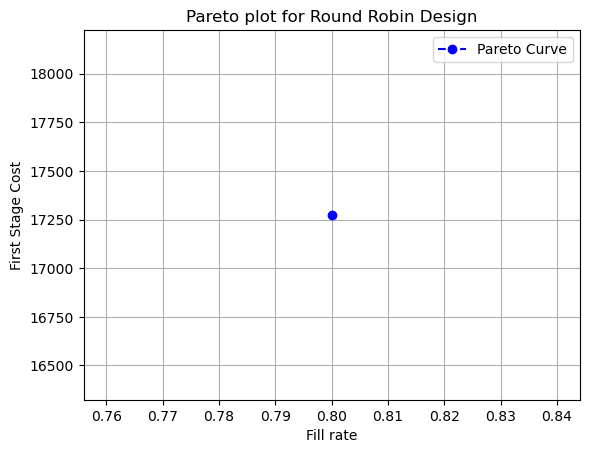

In [23]:
plt.plot(list(eps_fsc_dict.keys()), [eps_fsc_dict[e] for e in eps_fsc_dict], marker='o', linestyle='--', color='b', label="Pareto Curve")
plt.xlabel("Fill rate")
plt.ylabel("First Stage Cost")
plt.title("Pareto plot for Round Robin Design")
plt.legend()  # Show legend
plt.grid(True)  # Add grid
plt.show()  # Display the plot

In [24]:
eps_fsc_dict

{0.8: 17274.075}

In [25]:
eps_model_dict

{0.8: <mpisppy.opt.ef.ExtensiveForm at 0x247d7cd15d0>}

In [26]:
iter_model_dict

defaultdict(dict,
            {0.8: {1: <mpisppy.opt.ef.ExtensiveForm at 0x247ca004ac0>,
              2: <mpisppy.opt.ef.ExtensiveForm at 0x247d06ec760>,
              3: <mpisppy.opt.ef.ExtensiveForm at 0x247d06ed9f0>,
              4: <mpisppy.opt.ef.ExtensiveForm at 0x247d7cd15d0>}})

In [31]:
iter_selected_scenario_names

defaultdict(dict,
            {0.8: {1: ['truck25_2 res6_2 cap4_nd truck47_nd cap2_3',
               'truck25_1 res6_2 cap4_2 truck47_2 cap2_2',
               'truck25_1 res6_1 cap4_nd truck47_1 cap2_nd',
               'truck25_1 res6_1 cap4_1 truck47_1 cap2_3'],
              2: ['truck25_2 res6_2 cap4_nd truck47_nd cap2_3',
               'truck25_1 res6_2 cap4_2 truck47_2 cap2_2',
               'truck25_1 res6_1 cap4_nd truck47_1 cap2_nd',
               'truck25_1 res6_1 cap4_1 truck47_1 cap2_3'],
              3: ['truck25_2 res6_2 cap4_nd truck47_nd cap2_3',
               'truck25_1 res6_2 cap4_2 truck47_2 cap2_2',
               'truck25_1 res6_1 cap4_nd truck47_1 cap2_nd',
               'truck25_1 res6_1 cap4_1 truck47_1 cap2_3'],
              4: ['truck25_2 res6_2 cap4_nd truck47_nd cap2_3',
               'truck25_1 res6_2 cap4_2 truck47_2 cap2_2',
               'truck25_1 res6_1 cap4_nd truck47_1 cap2_nd',
               'truck25_1 res6_1 cap4_1 truck47_1 cap2_3']}})

In [32]:
iter_selected_scenario_dict

defaultdict(dict,
            {0.8: {1: {'truck25_2 res6_2 cap4_nd truck47_nd cap2_3': {'prob': 1.0,
                'factor':           loc2         loc4     loc6       truck25       truck47
                  com1_process com1_process com1_pur com1_loc2_out com1_loc4_out
                0          1.0          1.0      1.0           1.0           1.0
                1          1.0          1.0      1.0           1.0           1.0
                2          1.0          1.0      0.0           0.0           1.0
                3          0.0          1.0      0.0           0.0           1.0}},
              2: {'truck25_2 res6_2 cap4_nd truck47_nd cap2_3': {'prob': 0.9972856137528904,
                'factor':           loc2         loc4     loc6       truck25       truck47
                  com1_process com1_process com1_pur com1_loc2_out com1_loc4_out
                0          1.0          1.0      1.0           1.0           1.0
                1          1.0          1.0      1.0  

In [38]:
temp = defaultdict(dict)

In [39]:
for eps in iter_selected_scenario_dict:
    for iter in iter_selected_scenario_dict[eps]:
        temp[eps][iter] = list(iter_selected_scenario_dict[eps][iter].keys())

In [40]:
temp

defaultdict(dict,
            {0.8: {1: ['truck25_2 res6_2 cap4_nd truck47_nd cap2_3'],
              2: ['truck25_2 res6_2 cap4_nd truck47_nd cap2_3',
               'truck25_1 res6_2 cap4_2 truck47_2 cap2_2'],
              3: ['truck25_2 res6_2 cap4_nd truck47_nd cap2_3',
               'truck25_1 res6_2 cap4_2 truck47_2 cap2_2',
               'truck25_1 res6_1 cap4_nd truck47_1 cap2_nd'],
              4: ['truck25_2 res6_2 cap4_nd truck47_nd cap2_3',
               'truck25_1 res6_2 cap4_2 truck47_2 cap2_2',
               'truck25_1 res6_1 cap4_nd truck47_1 cap2_nd',
               'truck25_1 res6_1 cap4_1 truck47_1 cap2_3']}})